In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines as lfl

In [5]:
colon = pd.read_csv('colon.csv')

In [6]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=colon['time'], event_observed=colon['status'])

# Raw event table
event_table = kmf.event_table.reset_index().rename(
    columns={'event_at': 'time',
             'removed': 'at_risk',
             'observed': 'events',
             'censored': 'censored'}
)
print(event_table.head(10))


   time  at_risk  events  censored  entrance  at_risk
0   0.0        0       0         0       888      888
1   8.0        1       1         0         0      888
2   9.0        1       1         0         0      887
3  19.0        1       1         0         0      886
4  20.0        1       1         0         0      885
5  23.0        1       0         1         0      884
6  24.0        1       0         1         0      883
7  28.0        1       1         0         0      882
8  35.0        1       1         0         0      881
9  36.0        1       1         0         0      880


In [11]:

T = colon['time']
E = colon['status']

# 2. Define fixed intervals, e.g. 0–30, 30–60, … up to max time
max_time = int(T.max())
interval_width = 30
breaks = np.arange(0, max_time + interval_width, interval_width)

# 3. Build the life table
rows = []
for start, stop in zip(breaks[:-1], breaks[1:]):
    # people who enter the interval
    at_risk = ((T >= start) & (T < stop)).sum() + (T >= stop).sum()
    # events in [start, stop)
    events = ((T >= start) & (T < stop) & (E == 1)).sum()
    # censored in [start, stop)
    censored = ((T >= start) & (T < stop) & (E == 0)).sum()
    rows.append({
        'interval_start': start,
        'interval_end': stop,
        'at_risk': at_risk,
        'events': events,
        'censored': censored
    })

life_table = pd.DataFrame(rows)
print(life_table)


     interval_start  interval_end  at_risk  events  censored
0                 0            30      888       5         2
1                30            60      881       8         2
2                60            90      871      18         0
3                90           120      853      24         0
4               120           150      829      14         0
..              ...           ...      ...     ...       ...
106            3180          3210        7       0         2
107            3210          3240        5       0         1
108            3240          3270        4       0         0
109            3270          3300        4       0         0
110            3300          3330        4       0         4

[111 rows x 5 columns]


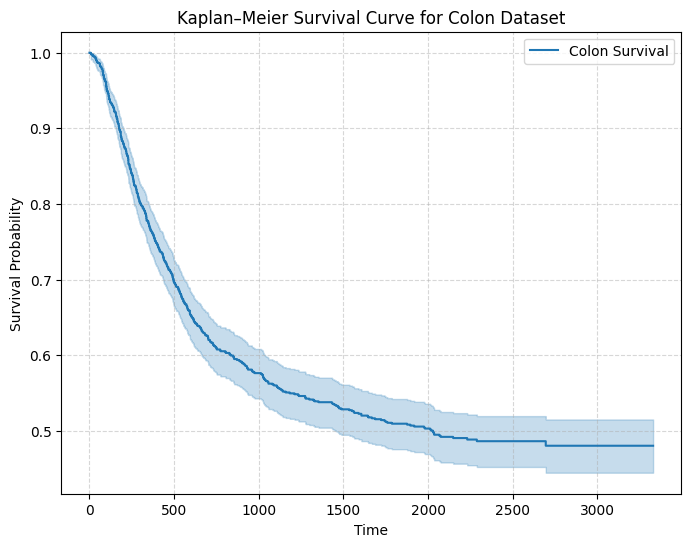

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, label='Colon Survival')

# 3. Plot survival function
plt.figure(figsize=(8, 6))
kmf.plot_survival_function(ci_show=True)
plt.title('Kaplan–Meier Survival Curve for Colon Dataset')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# wybor zmiennych do modelu

from lifelines.statistics import logrank_test

colon['age_high'] = (colon['age'] > colon['age'].median()).astype(int)
ix_low  = colon['age_high'] == 0
ix_high = colon['age_high'] == 1

results = logrank_test(
    colon.loc[ix_low,  'time'], 
    colon.loc[ix_high, 'time'],
    event_observed_A=colon.loc[ix_low,  'status'],
    event_observed_B=colon.loc[ix_high, 'status']
)
print(f"p‑value = {results.p_value:.4f}")
print(results.summary)


p‑value = 0.7837
   test_statistic         p  -log2(p)
0         0.07532  0.783743  0.351548


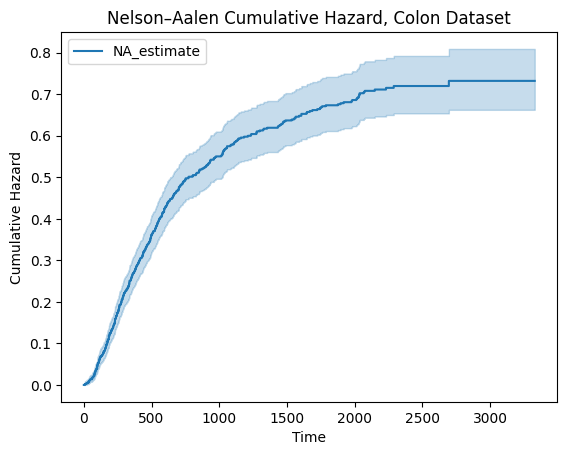

In [9]:
from lifelines import NelsonAalenFitter
import matplotlib.pyplot as plt

naf = NelsonAalenFitter()
naf.fit(durations=colon['time'], event_observed=colon['status'])

# Plot cumulative hazard
naf.plot_cumulative_hazard()
plt.title("Nelson–Aalen Cumulative Hazard, Colon Dataset")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.show()
